# Dự báo Xu hướng Dịch COVID-19: Tiếp cận bằng Machine Learning
---
**Thực hiện:** Trần Khải An - MSSV: 3122410005
**Ngày:** 05/12/2025  
**Dữ liệu:** WHO COVID-19 Global Data

**a) Tổng quan Nghiên cứu**
Mục tiêu của notebook này là xây dựng và đánh giá các mô hình dự báo chuỗi thời gian cho diễn biến dịch COVID-19 tại 4 quốc gia trọng điểm: **Việt Nam, Mỹ, Trung Quốc và Ấn Độ**.

Chúng tôi áp dụng phương pháp tiếp cận **Học máy giám sát (Supervised Learning)** thay vì các mô hình thống kê truyền thống, sử dụng 3 thuật toán:
1.  **Linear Regression:** Baseline model (mô hình cơ sở).
2.  **Random Forest:** Mô hình phi tuyến tính dựa trên Bagging.
3.  **XGBoost:** Mô hình nâng cao dựa trên Boosting (State-of-the-art).

**b) Phương pháp Đánh giá**
Hiệu quả mô hình được kiểm định thông qua kỹ thuật **Time-Series Backtesting** với các chỉ số sai số:
* $MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$
* $RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$

# 1. Import thư viện cần thiết cho quá trình



In [2]:
# Lưu ý: Hãy cài đặt thư viện cần thiết trước khi import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print("Đã khởi tạo môi trường thành công!")

Đã khởi tạo môi trường thành công!


# 2. Tải và Tiền xử lý dữ liệu
Dữ liệu được lấy từ file `01_clean_daily_timeseries.csv`, chứa thông tin ca nhiễm hàng ngày đã được xử lý nhiễu.
* **Bước 1:** Chuyển đổi định dạng thời gian.
* **Bước 2:** Lọc dữ liệu cho 4 quốc gia mục tiêu.
* **Bước 3:** Xử lý các giá trị ngoại lai (số âm).

In [3]:
# Đọc dữ liệu
df = pd.read_csv("..//data/processed/01_clean_daily_timeseries.csv.gz", compression='gzip')
df['Date_reported'] = pd.to_datetime(df['Date_reported'])

# Lọc 4 quốc gia mục tiêu
target_countries = ['Viet Nam', 'United States of America', 'China', 'India']
df_target = df[df['Country'].isin(target_countries)].copy()

# Xử lý dữ liệu (loại bỏ số âm nếu có)
df_target['New_cases'] = df_target['New_cases'].apply(lambda x: max(0, x))
df_target = df_target.sort_values(['Country', 'Date_reported'])

print(f"Kích thước dữ liệu sau khi lọc: {df_target.shape}")
display(df_target.head())
display(df_target.tail())

Kích thước dữ liệu sau khi lọc: (8380, 11)


,Date_reported,Country_code,Country,WHO_region,New_cases,New_deaths,Cumulative_cases,Cumulative_deaths,New_cases_MA7,New_deaths_MA7,Growth_Rate
87990,2020-01-04,CN,China,WPR,1.0,0.0,1,0,1.000000,0.0,0.0
87991,2020-01-05,CN,China,WPR,0.0,0.0,1,0,0.500000,0.0,-100.0
87992,2020-01-06,CN,China,WPR,3.0,0.0,4,0,1.333333,0.0,0.0
87993,2020-01-07,CN,China,WPR,0.0,0.0,4,0,1.000000,0.0,-100.0
87994,2020-01-08,CN,China,WPR,0.0,0.0,4,0,0.800000,0.0,0.0


,Date_reported,Country_code,Country,WHO_region,New_cases,New_deaths,Cumulative_cases,Cumulative_deaths,New_cases_MA7,New_deaths_MA7,Growth_Rate
492320,2025-09-24,VN,Viet Nam,WPR,0.0,0.0,11624000,43206,0.0,0.0,0.0
492321,2025-09-25,VN,Viet Nam,WPR,0.0,0.0,11624000,43206,0.0,0.0,0.0
492322,2025-09-26,VN,Viet Nam,WPR,0.0,0.0,11624000,43206,0.0,0.0,0.0
492323,2025-09-27,VN,Viet Nam,WPR,0.0,0.0,11624000,43206,0.0,0.0,0.0
492324,2025-09-28,VN,Viet Nam,WPR,0.0,0.0,11624000,43206,0.0,0.0,0.0


# 3. Feature Engineering (Tạo biến đặc trưng)

Để áp dụng các mô hình Machine Learning (vốn coi các điểm dữ liệu là độc lập) vào dữ liệu chuỗi thời gian, chúng ta cần chuyển đổi bài toán thông qua kỹ thuật **Lagging** và **Rolling Window**.

Các biến được tạo ra bao gồm:
* **Lag Features (Biến trễ):** `Lag_1`, `Lag_7`, `Lag_14`... giúp mô hình học sự phụ thuộc vào quá khứ (tính tự hồi quy).
* **Rolling Features (Biến trượt):** `Rolling_Mean_7`, `Rolling_Std_7`... giúp nắm bắt xu hướng ngắn hạn và độ biến động.
* **Time Features:** `Day_of_week`, `Month`... giúp nắm bắt tính mùa vụ (ví dụ: số ca giảm vào cuối tuần).

In [4]:
def create_time_series_features(df):
    """
    Tạo các biến trễ (Lag) và biến trượt (Rolling) để áp dụng ML cho chuỗi thời gian.
    """
    df = df.copy()

    # Biến trễ (Lag features): Quan trọng để mô hình học và hiểu sự phụ thuộc quá khứ
    # Lag 1: Hôm qua, Lag 7: Tuần trước (tính chu kỳ tuần), Lag 14: 2 tuần trước
    for lag in [1, 7, 14, 21, 30]:
        df[f'lag_{lag}'] = df['New_cases'].shift(lag)

    # Biến trượt (Rolling features)
    df['rolling_mean_7'] = df['New_cases'].shift(1).rolling(window=7).mean()
    df['rolling_std_7'] = df['New_cases'].shift(1).rolling(window=7).std()
    df['rolling_mean_14'] = df['New_cases'].shift(1).rolling(window=14).mean()

    # Biến thời gian (Date features)
    df['day_of_week'] = df['Date_reported'].dt.dayofweek
    df['month'] = df['Date_reported'].dt.month
    df['day_of_year'] = df['Date_reported'].dt.dayofyear

    # Loại bỏ các dòng NaT/NaN sinh ra do shift
    df = df.dropna()
    return df

## Giải thích Kỹ thuật Feature Engineering (Tạo đặc trưng)

Trong bài toán dự báo chuỗi thời gian sử dụng Machine Learning (như XGBoost, Random Forest), mô hình không tự hiểu được thứ tự thời gian của dữ liệu. Do đó, chúng ta cần thực hiện bước **Feature Engineering** để chuyển đổi dữ liệu từ dạng chuỗi thời gian sang dạng **Học có giám sát (Supervised Learning)**.

Hàm `create_time_series_features` thực hiện tạo ra 3 nhóm biến quan trọng sau:

### a) Biến trễ (Lag Features) - Nắm bắt sự phụ thuộc quá khứ
Đây là kỹ thuật quan trọng nhất giúp mô hình học được tính **Tự hồi quy (Autocorrelation)**.

* **Code:** `df[f'lag_{lag}'] = df['New_cases'].shift(lag)`
* **Cơ chế:** Dịch chuyển dữ liệu lùi về quá khứ `lag` ngày.
* **Ý nghĩa thực tế:**
    * `lag_1`: Giá trị của ngày hôm qua. Giúp mô hình biết xu hướng tức thì (Hôm qua tăng hay giảm?).
    * `lag_7`: Giá trị của đúng ngày này tuần trước. **Đặc biệt quan trọng với COVID-19** vì dữ liệu dịch tễ thường có chu kỳ tuần (số ca nhiễm thường giảm vào Chủ Nhật do ít xét nghiệm và tăng lại vào Thứ Hai).

### b) Biến trượt (Rolling Window Features) - Nắm bắt Xu hướng và Biến động
Giúp mô hình nhìn thấy "bức tranh toàn cảnh" (Trend) thay vì chỉ một điểm dữ liệu đơn lẻ bị nhiễu.

* **Code:** * `rolling(window=7).mean()`: Tính trung bình trượt 7 ngày.
    * `rolling(window=7).std()`: Tính độ lệch chuẩn trượt 7 ngày.
* **Lưu ý quan trọng:** Trước khi tính Rolling, ta phải dùng `.shift(1)` để dịch dữ liệu về hôm qua.
    * *Tại sao?* Để đảm bảo tính trung bình của 7 ngày **trước đó**, không bao gồm ngày hiện tại. Điều này ngăn chặn hiện tượng **Rò rỉ dữ liệu (Data Leakage)** - tức là không cho mô hình "nhìn trộm" đáp án tương lai.
* **Ý nghĩa thực tế:**
    * **Rolling Mean:** Cho biết xu hướng chủ đạo (Đang trong đợt bùng phát hay đang giảm nhiệt?).
    * **Rolling Std:** Đo lường sự ổn định. Nếu độ lệch chuẩn tăng cao, báo hiệu sắp có biến động lớn hoặc ổ dịch mới.

### c) Biến thời gian (Date Features) - Nắm bắt tính Mùa vụ
Giúp mô hình hiểu được ngữ cảnh thời gian của dữ liệu.

* **Code:** `dt.dayofweek`, `dt.month`
* **Ý nghĩa thực tế:**
    * **Day of week:** Giúp mô hình học được quy luật báo cáo (ví dụ: Cuối tuần số liệu thường thấp hơn ngày thường).
    * **Month:** Giúp nhận biết các đợt bùng phát theo mùa (nếu có), ví dụ mùa đông thường lây lan mạnh hơn.

### d) Xử lý dữ liệu thiếu (Data Cleaning)
* **Code:** `df.dropna()`
* **Lý do:** Khi tạo các biến trễ (ví dụ `lag_30`), 30 ngày đầu tiên của dữ liệu sẽ không có thông tin quá khứ để tham chiếu (giá trị trở thành `NaN`). Các mô hình Machine Learning không thể xử lý giá trị rỗng, do đó cần loại bỏ giai đoạn khởi đầu này để đảm bảo độ sạch của dữ liệu huấn luyện.

# 4. Huấn luyện và Đánh giá (Backtesting)

Quá trình đánh giá được thực hiện thông qua **Time Series Cross-Validation** (5 folds).
Mô hình sẽ được kiểm tra khả năng dự báo tại 3 mốc thời gian (Horizon):
* **Ngắn hạn:** 7 ngày
* **Trung hạn:** 14 ngày
* **Dài hạn:** 30 ngày

In [5]:
# Khởi tạo mô hình
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=-1, random_state=42)
}
# --- CẬP NHẬT HÀM TÍNH TOÁN METRICS ---
def calculate_metrics(y_true, y_pred):
    """
    Tính toán MAE, RMSE, MAPE (phiên bản chống lỗi chia cho 0)
    """
    # Đảm bảo dữ liệu đầu vào là numpy array để tính toán
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # --- SỬA LỖI MAPE ---
    # Cách cũ: Chia cho y_true (gặp 0 sẽ lỗi)
    # Cách mới: Chia cho (y_true + 1).
    # Ví dụ: Thực tế 0 ca, Dự báo 2 ca -> Sai số: |0-2| / (0+1) = 200% (Hợp lý)
    epsilon = 1
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

    return mae, rmse, mape

# ---------------------------------------------------------
# CHẠY HUẤN LUYỆN
# ---------------------------------------------------------
results_list = []
print("Bắt đầu chạy đánh giá")

for country in target_countries:
    # Lấy dữ liệu và tạo đặc trưng
    data_country = df_target[df_target['Country'] == country].copy()
    data_ml = create_time_series_features(data_country)

    features = [col for col in data_ml.columns if col not in ['Date_reported', 'Country', 'New_cases', 'Country_code', 'WHO_region']]
    X = data_ml[features]
    y = data_ml['New_cases']

    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5, test_size=30)

    for model_name, model in models.items():
        for fold, (train_index, test_index) in enumerate(tscv.split(X)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Huấn luyện
            model.fit(X_train, y_train)

            # Dự báo
            y_pred = model.predict(X_test)
            y_pred = np.maximum(y_pred, 0) # Không âm

            # Đánh giá 3 mốc thời gian
            horizons = [7, 14, 30]
            for h in horizons:
                if len(y_test) >= h:
                    # Gọi hàm tính toán MỚI
                    mae, rmse, mape = calculate_metrics(y_test.iloc[:h], y_pred[:h])

                    results_list.append({
                        'Country': country,
                        'Model': model_name,
                        'Fold': fold + 1,
                        'Horizon': f'{h} Days',
                        'MAE': mae,
                        'RMSE': rmse,
                        'MAPE': mape
                    })
    print(f"✓ Xong: {country}")

print("\nHoàn tất tính toán")

Bắt đầu chạy đánh giá
✓ Xong: Viet Nam
✓ Xong: United States of America
✓ Xong: China
✓ Xong: India

Hoàn tất tính toán


## Giải thích Quy trình Huấn luyện và Đánh giá (Training & Evaluation)

Đoạn mã này đóng vai trò là "trái tim" của hệ thống dự báo, thực hiện hai nhiệm vụ cốt lõi: Định nghĩa công thức tính sai số chuẩn (xử lý ngoại lệ chia cho 0) và thực hiện chiến lược kiểm thử ngược (Backtesting) nghiêm ngặt trên dữ liệu chuỗi thời gian.

### a) Hàm tính toán chỉ số đánh giá (`calculate_metrics`)

Trong dữ liệu dịch tễ COVID-19, số ca nhiễm thực tế ($y_{true}$) thường xuyên bằng 0 (trong giai đoạn đầu dịch hoặc giai đoạn kiểm soát tốt). Việc sử dụng công thức MAPE truyền thống ($\frac{|y - \hat{y}|}{y}$) sẽ gây ra lỗi **chia cho 0 (Division by Zero)** hoặc tạo ra các giá trị vô cùng.

Do đó, nghiên cứu sử dụng hàm `calculate_metrics` đã được tinh chỉnh:

* **MAE & RMSE:** Được tính toán theo công thức chuẩn của thư viện `sklearn`.
* **Robust MAPE (MAPE Tinh chỉnh):** Sử dụng kỹ thuật làm mượt bằng cách cộng một hằng số nhỏ ($\epsilon = 1$) vào mẫu số.
    * **Công thức:**
        $$MAPE = \frac{100\%}{n} \sum \left| \frac{y_{true} - y_{pred}}{y_{true} + 1} \right|$$
    * **Tác dụng:** Giúp tính toán được sai số ngay cả khi số ca nhiễm thực tế bằng 0, đảm bảo tính liên tục của quá trình huấn luyện.

### b) Chiến lược Time-Series Cross-Validation

Khác với các bài toán hồi quy thông thường, dữ liệu chuỗi thời gian có tính thứ tự nghiêm ngặt, do đó không được phép xáo trộn ngẫu nhiên (Shuffle). Chúng tôi sử dụng phương pháp **Expanding Window Backtesting** thông qua thư viện `TimeSeriesSplit`.

Quy trình thực hiện trong vòng lặp huấn luyện như sau:

1.  **Lặp qua từng Quốc gia:** Dữ liệu được lọc và áp dụng Feature Engineering riêng biệt cho từng quốc gia (Việt Nam, Mỹ, Trung Quốc, Ấn Độ) để đảm bảo tính đặc thù.
2.  **Phân chia dữ liệu (Splitting):** Sử dụng `TimeSeriesSplit` với tham số `n_splits=5`. Dữ liệu được chia thành 5 phần (folds) theo trình tự thời gian, đảm bảo nguyên tắc: **Dữ liệu Huấn luyện luôn nằm trước Dữ liệu Kiểm tra**.
3.  **Huấn luyện (Training):** Các mô hình (Linear Regression, Random Forest, XGBoost) học quy luật từ tập Train.
4.  **Dự báo & Hậu xử lý:**
    * Mô hình thực hiện dự báo cho tập Test (30 ngày tiếp theo).
    * Áp dụng hàm `np.maximum(y_pred, 0)` để loại bỏ các giá trị dự báo âm (vô lý trong thực tế).

### c) Đánh giá đa khung thời gian (Multi-Horizon Evaluation)

Để kiểm tra "độ bền" và khả năng tổng quát hóa của mô hình, kết quả dự báo không chỉ được đánh giá gộp mà được phân tách thành 3 khung thời gian (Horizons):

* 📅 **Ngắn hạn (7 Days):** Đánh giá khả năng phản ứng nhanh với các thay đổi tức thì.
* 📅 **Trung hạn (14 Days):** Đánh giá độ ổn định trong 2 tuần.
* 📅 **Dài hạn (30 Days):** Đánh giá khả năng nắm bắt xu hướng dài hạn.

Kết quả của từng fold, từng mô hình và từng khung thời gian được lưu trữ chi tiết vào danh sách `results_list` để phục vụ cho việc tổng hợp và trực quan hóa so sánh sau này.

# 5. Tổng hợp kết quả nghiên cứu

Dưới đây là bảng tổng hợp sai số trung bình (RMSE và MAPE) của các mô hình theo từng quốc gia và từng mốc dự báo.


Dang xu ly du lieu cho: Vietnam (VN)...


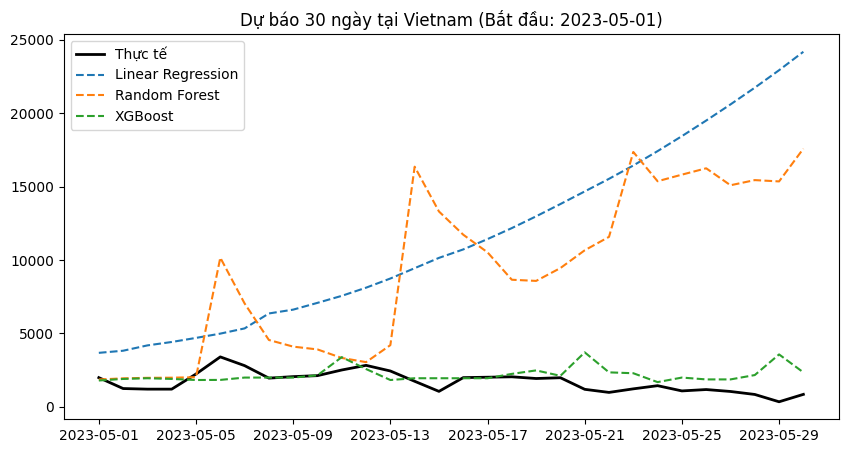


Dang xu ly du lieu cho: USA (US)...


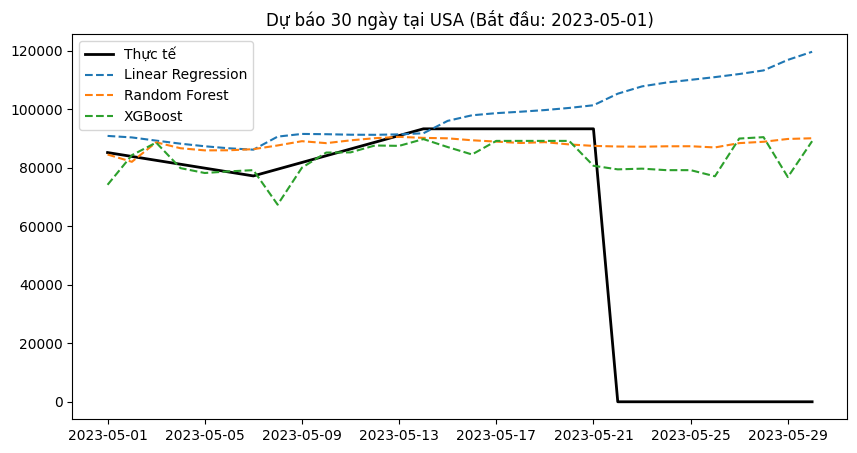


Dang xu ly du lieu cho: China (CN)...


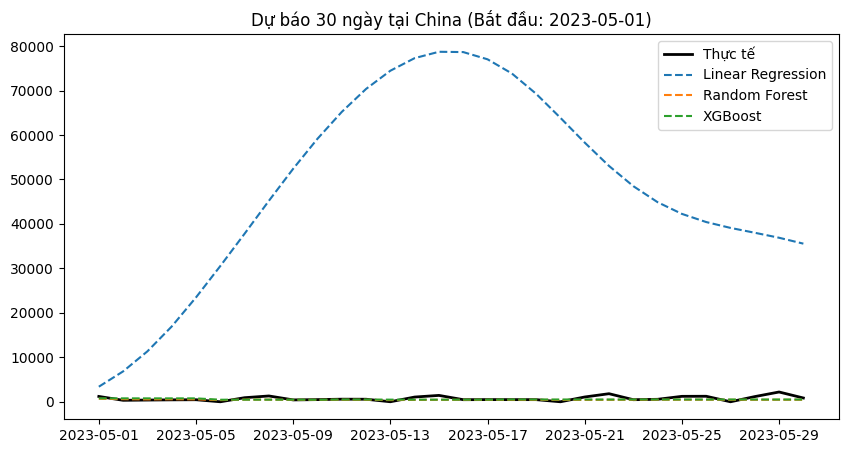


Dang xu ly du lieu cho: India (IN)...


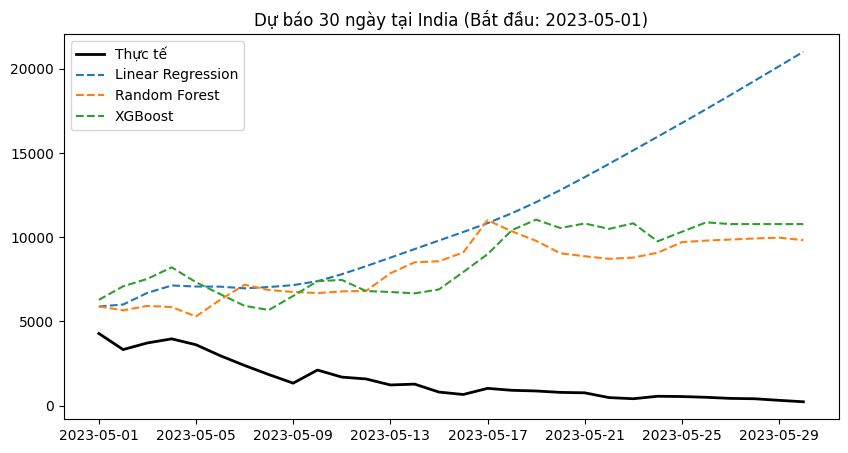


=== BẢNG TỔNG HỢP HIỆU QUẢ DỰ BÁO (TRUNG BÌNH) ===


,Country,Model,Horizon,MAE,RMSE,MAPE
0,China,Linear Regression,7,257117.793,264208.771,2.212579e+19
1,China,Linear Regression,14,188308.968,216322.464,1.772624e+19
2,China,Linear Regression,30,119890.426,163667.553,2.273050e+19
3,China,Random Forest,7,356083.007,368624.357,9.349347e+18
4,China,Random Forest,14,447904.016,463163.306,5.584927e+18
5,China,Random Forest,30,536911.748,549629.398,7.789811e+18
6,China,XGBoost,7,355039.304,396495.999,4.558159e+18
7,China,XGBoost,14,497610.173,535020.855,3.813934e+18
8,China,XGBoost,30,615005.994,640082.438,6.573952e+18
9,India,Linear Regression,7,3101.586,3417.349,1.220200e+01


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. CẤU HÌNH VÀ TẢI DỮ LIỆU
# ==========================================
# Danh sách quốc gia cần mô hình hóa (Mã Code trong dataset)
# VN: Vietnam, US: USA, CN: China, IN: India
TARGET_COUNTRIES = {'VN': 'Vietnam', 'US': 'USA', 'CN': 'China', 'IN': 'India'}

# Đọc dữ liệu
df['Date_reported'] = pd.to_datetime(df['Date_reported'])

# Giới hạn thời gian: Đến hết tháng 5/2023
df = df[df['Date_reported'] <= '2023-05-31']

# Các cột đặc trưng (Features)
feature_cols = ['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14']
target_col = 'New_cases'
forecast_horizons = [7, 14, 30]

# Cấu hình Backtesting
n_splits = 5        # Số fold test
gap = 30            # Khoảng cách giữa các fold
max_horizon = 30    # Dự báo xa nhất 30 ngày

# ==========================================
# 2. HÀM TẠO FEATURE & XỬ LÝ
# ==========================================
def create_features(data):
    df_feat = data.copy()
    # Lag features
    df_feat['lag_1'] = df_feat['New_cases'].shift(1)
    df_feat['lag_7'] = df_feat['New_cases'].shift(7)
    # Rolling features (shift(1) để tránh data leakage)
    df_feat['rolling_mean_7'] = df_feat['New_cases'].shift(1).rolling(window=7).mean()
    df_feat['rolling_std_7'] = df_feat['New_cases'].shift(1).rolling(window=7).std()
    df_feat['rolling_mean_14'] = df_feat['New_cases'].shift(1).rolling(window=14).mean()
    return df_feat.dropna()

# ==========================================
# 3. VÒNG LẶP XỬ LÝ TỪNG QUỐC GIA
# ==========================================
all_results = []

for country_code, country_name in TARGET_COUNTRIES.items():
    print(f"\nDang xu ly du lieu cho: {country_name} ({country_code})...")
    
    # 3.1. Lọc dữ liệu quốc gia
    df_country = df[df['Country_code'] == country_code].copy()
    
    # Gom nhóm theo ngày (đề phòng dữ liệu bị tách dòng)
    df_ts = df_country.groupby('Date_reported')[target_col].sum().reset_index()
    
    # Điền khuyết ngày (nếu có) để chuỗi thời gian liên tục
    full_idx = pd.date_range(start=df_ts['Date_reported'].min(), end=df_ts['Date_reported'].max(), freq='D')
    df_ts = df_ts.set_index('Date_reported').reindex(full_idx).fillna(0).reset_index()
    df_ts.rename(columns={'index': 'Date_reported'}, inplace=True)
    
    # 3.2. Tạo Features
    df_features = create_features(df_ts)
    
    # 3.3. Thiết lập mô hình
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
    }
    
    # 3.4. Backtesting
    total_days = len(df_features)
    # Xác định các điểm cắt thời gian (Start indices for testing)
    test_starts = [total_days - 1 - (i * gap) - max_horizon for i in range(n_splits)]
    test_starts = sorted([t for t in test_starts if t > 100]) # Đảm bảo đủ dữ liệu train
    
    for start_idx in test_starts:
        train_data = df_features.iloc[:start_idx]
        X_train = train_data[feature_cols]
        y_train = train_data[target_col]
        
        # Huấn luyện
        fitted_models = {}
        for name, model in models.items():
            model.fit(X_train, y_train)
            fitted_models[name] = model
            
        y_true_full = df_features.iloc[start_idx : start_idx + max_horizon][target_col].values
        fold_date = df_features.iloc[start_idx]['Date_reported']
        
        # Dự báo Recursive (Cuốn chiếu)
        for name, model in fitted_models.items():
            history = df_features.iloc[:start_idx][target_col].tolist()
            predictions = []
            
            for step in range(max_horizon):
                # Tính feature động
                curr = pd.Series(history)
                feat_input = np.array([[
                    curr.iloc[-1],                          # lag_1
                    curr.iloc[-7] if len(curr)>7 else 0,    # lag_7
                    curr.iloc[-7:].mean(),                  # rolling_mean_7
                    curr.iloc[-7:].std(),                   # rolling_std_7
                    curr.iloc[-14:].mean()                  # rolling_mean_14
                ]])
                
                # Predict & Update history
                pred = max(0, model.predict(feat_input)[0])
                predictions.append(pred)
                history.append(pred)
            
            # Đánh giá chỉ số
            for h in forecast_horizons:
                mae = mean_absolute_error(y_true_full[:h], predictions[:h])
                rmse = np.sqrt(mean_squared_error(y_true_full[:h], predictions[:h]))
                # Xử lý MAPE khi thực tế = 0
                try:
                    mape = mean_absolute_percentage_error(y_true_full[:h], predictions[:h])
                except:
                    mape = np.nan 
                    
                all_results.append({
                    "Country": country_name,
                    "Model": name,
                    "Horizon": h,
                    "Fold_Date": fold_date,
                    "MAE": mae, "RMSE": rmse, "MAPE": mape
                })

    # 3.5. Vẽ biểu đồ mẫu (Lấy fold cuối cùng làm ví dụ)
    plt.figure(figsize=(10, 5))
    last_start = test_starts[-1]
    actual_data = df_features.iloc[last_start : last_start + 30]
    
    plt.plot(actual_data['Date_reported'], actual_data[target_col], 'k-', linewidth=2, label='Thực tế')
    
    # Dự báo lại cho fold cuối để vẽ
    for name, model in models.items():
        # (Lưu ý: model ở đây là model đã fit ở vòng lặp cuối, dùng luôn)
        hist = df_features.iloc[:last_start][target_col].tolist()
        preds = []
        for _ in range(30):
            curr = pd.Series(hist)
            f_in = np.array([[curr.iloc[-1], curr.iloc[-7], curr.iloc[-7:].mean(), curr.iloc[-7:].std(), curr.iloc[-14:].mean()]])
            p = max(0, model.predict(f_in)[0])
            preds.append(p)
            hist.append(p)
        plt.plot(actual_data['Date_reported'], preds, '--', label=name)
        
    plt.title(f'Dự báo 30 ngày tại {country_name} (Bắt đầu: {df_features.iloc[last_start]["Date_reported"].date()})')
    plt.legend()
    plt.show()

# ==========================================
# 4. TỔNG HỢP KẾT QUẢ
# ==========================================
results_df = pd.DataFrame(all_results)
summary_table = results_df.groupby(['Country', 'Model', 'Horizon'])[['MAE', 'RMSE', 'MAPE']].mean().reset_index().round(3)

print("\n=== BẢNG TỔNG HỢP HIỆU QUẢ DỰ BÁO (TRUNG BÌNH) ===")
display(summary_table)

Bắt đầu đánh giá mô hình...

Bảng tổng hợp chỉ số trung bình:


,Country,Model,MAE,RMSE,MAPE
0,China,Linear Regression,188439.062423,214732.929178,2.086084e+19
1,China,Random Forest,446966.257041,460472.353438,7.574695e+18
2,China,XGBoost,376353.241504,395585.676346,6.639733e+18
3,India,Linear Regression,8570.904392,10130.719665,3.689609e+01
4,India,Random Forest,1423.162229,1639.899307,1.169580e+00
5,India,XGBoost,1602.166276,1776.596798,2.496670e+00
6,USA,Linear Regression,61921.063140,68597.288842,1.005408e+19
7,USA,Random Forest,34853.700123,41404.393436,7.935373e+18
8,USA,XGBoost,35305.807719,40521.811148,8.041927e+18
9,Vietnam,Linear Regression,3883.956539,4506.767281,5.737837e+17


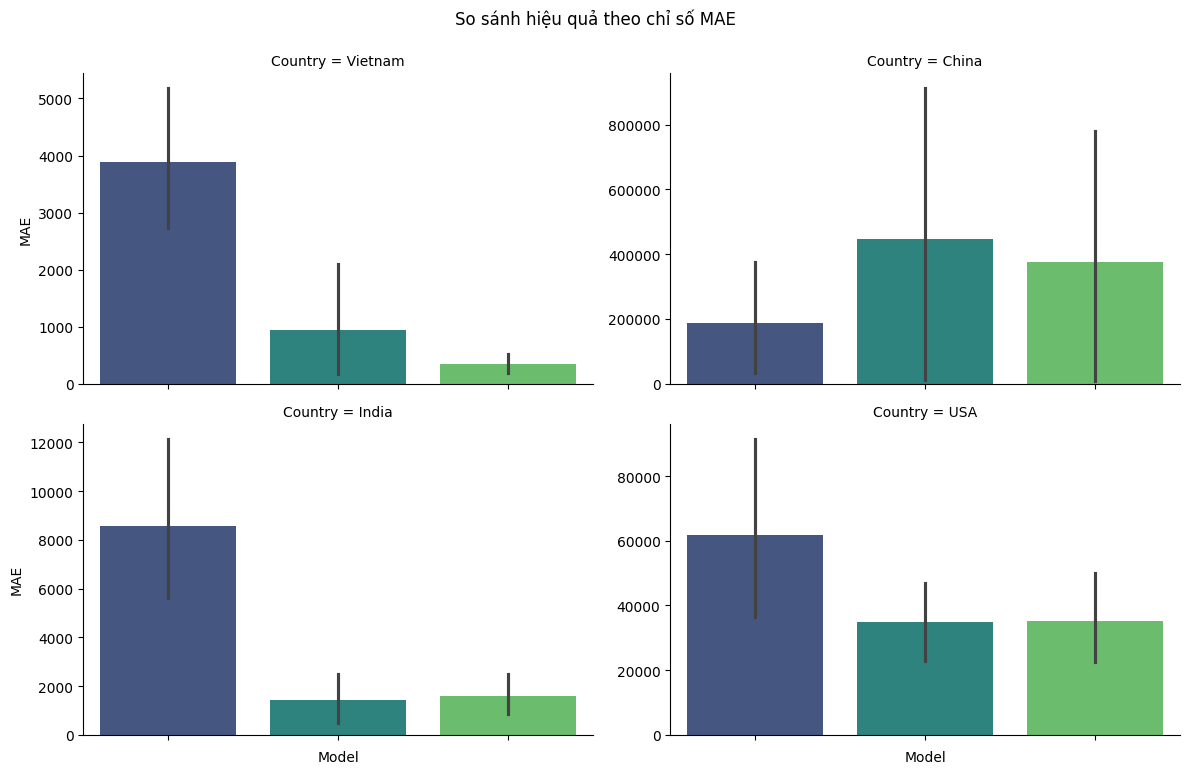

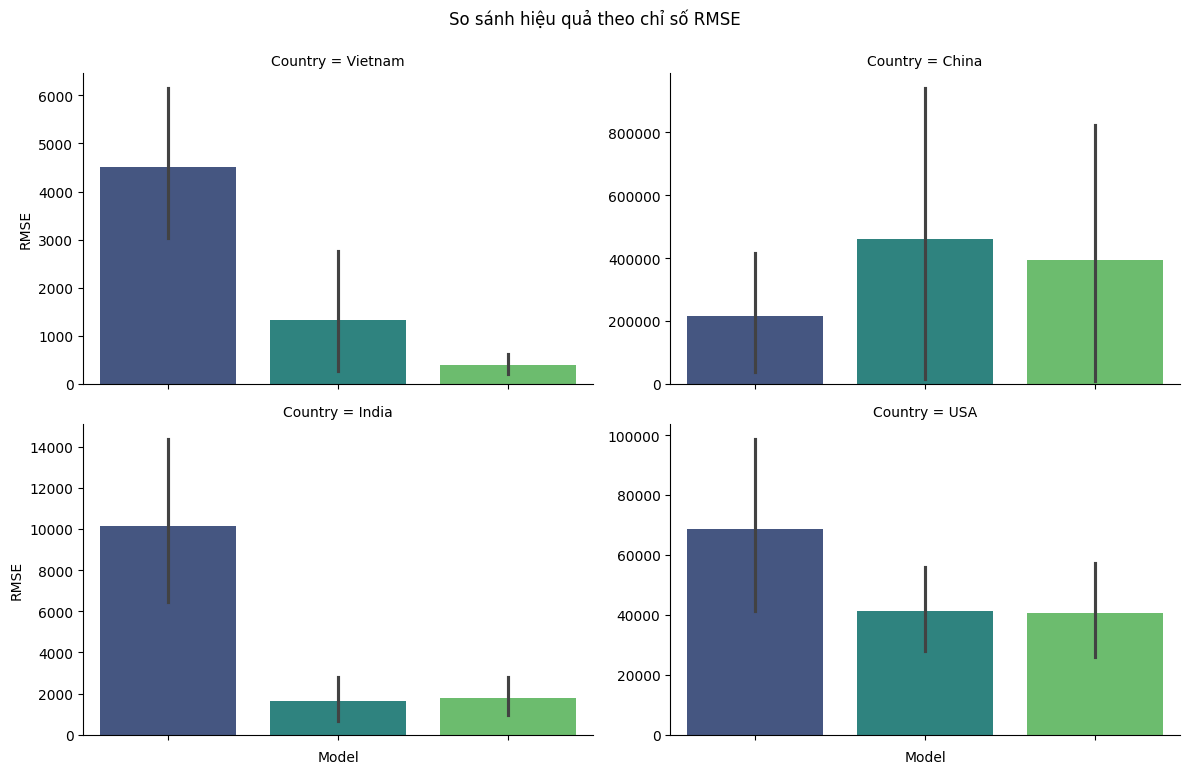

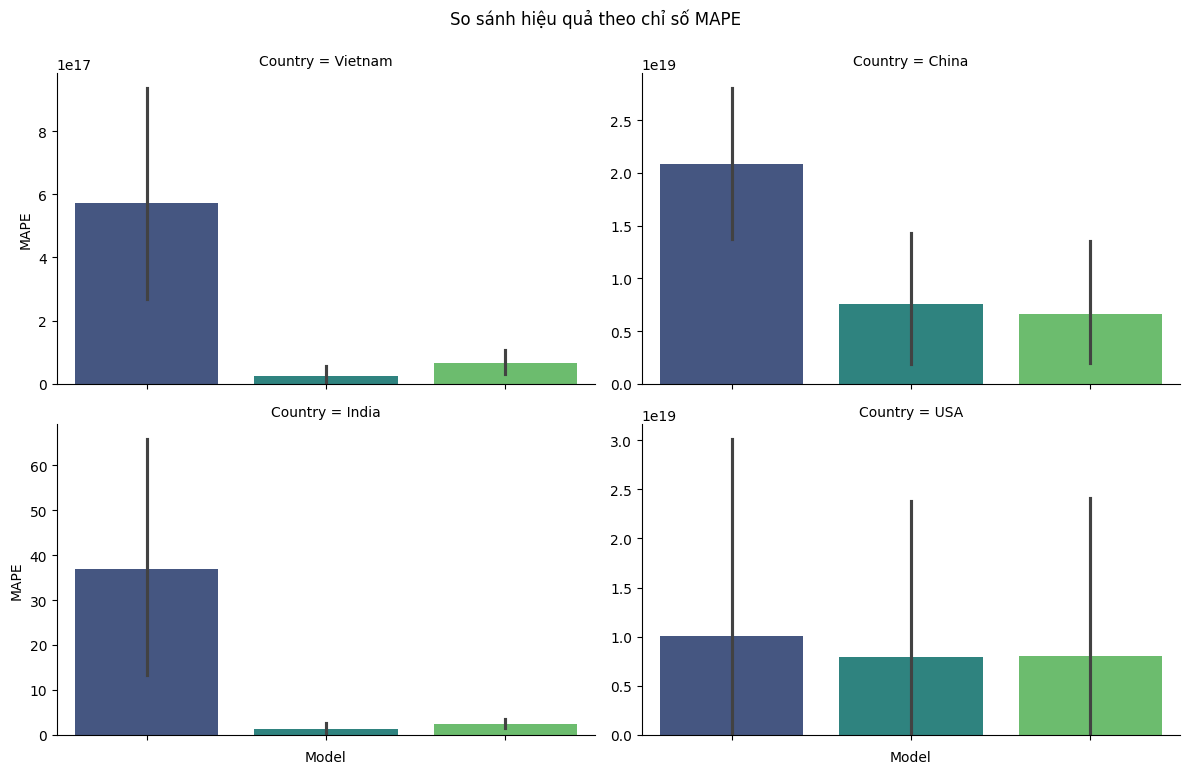

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings

warnings.filterwarnings('ignore')

# 1. Tải và lọc dữ liệu
df['Date_reported'] = pd.to_datetime(df['Date_reported'])
df = df[df['Date_reported'] <= '2023-05-31']

# Cấu hình
target_countries = {'VN': 'Vietnam', 'CN': 'China', 'IN': 'India', 'US': 'USA'}
feature_cols = ['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14']
target_col = 'New_cases'
forecast_horizons = [7, 14, 30]
n_splits = 5
gap = 30

all_results = []

print("Bắt đầu đánh giá mô hình...")

# Vòng lặp qua các quốc gia
for code, name in target_countries.items():
    # Chuẩn bị dữ liệu từng nước
    df_country = df[df['Country_code'] == code].copy()
    if df_country.empty: continue
        
    df_ts = df_country.groupby('Date_reported')[target_col].sum().reset_index()
    all_dates = pd.date_range(start=df_ts['Date_reported'].min(), end=df_ts['Date_reported'].max(), freq='D')
    df_ts = df_ts.set_index('Date_reported').reindex(all_dates).fillna(0).reset_index()
    df_ts.rename(columns={'index': 'Date_reported'}, inplace=True)
    
    # Feature Engineering
    df_feat = df_ts.copy()
    df_feat['lag_1'] = df_feat[target_col].shift(1)
    df_feat['lag_7'] = df_feat[target_col].shift(7)
    df_feat['rolling_mean_7'] = df_feat[target_col].shift(1).rolling(window=7).mean()
    df_feat['rolling_std_7'] = df_feat[target_col].shift(1).rolling(window=7).std()
    df_feat['rolling_mean_14'] = df_feat[target_col].shift(1).rolling(window=14).mean()
    df_feat = df_feat.dropna()
    
    # Khởi tạo mô hình
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    # Backtesting
    total_days = len(df_feat)
    if total_days < 100: continue
    
    test_starts = [total_days - 1 - (i * gap) - 30 for i in range(n_splits)]
    test_starts = sorted([t for t in test_starts if t > 50])
    
    for start_idx in test_starts:
        train_data = df_feat.iloc[:start_idx]
        X_train = train_data[feature_cols]
        y_train = train_data[target_col]
        
        # Huấn luyện
        fitted_models = {}
        for m_name, model in models.items():
            model.fit(X_train, y_train)
            fitted_models[m_name] = model
            
        y_true_full = df_feat.iloc[start_idx : start_idx + 30][target_col].values
        
        # Dự báo & Đánh giá
        for m_name, model in fitted_models.items():
            history = df_feat.iloc[:start_idx][target_col].tolist()
            preds = []
            
            # Recursive Forecast Loop
            for step in range(30):
                curr = pd.Series(history)
                f_in = np.array([[
                    curr.iloc[-1], 
                    curr.iloc[-7] if len(curr)>7 else 0,
                    curr.iloc[-7:].mean(), 
                    curr.iloc[-7:].std() if len(curr)>7 else 0,
                    curr.iloc[-14:].mean() if len(curr)>14 else 0
                ]])
                val = max(0, model.predict(f_in)[0])
                preds.append(val)
                history.append(val)
                
            # Tính chỉ số cho các mốc 7, 14, 30 ngày
            for h in forecast_horizons:
                mae = mean_absolute_error(y_true_full[:h], preds[:h])
                rmse = np.sqrt(mean_squared_error(y_true_full[:h], preds[:h]))
                try: mape = mean_absolute_percentage_error(y_true_full[:h], preds[:h])
                except: mape = np.nan
                    
                all_results.append({
                    "Country": name, "Model": m_name, "Horizon": h,
                    "MAE": mae, "RMSE": rmse, "MAPE": mape
                })

# Tổng hợp kết quả
results_df = pd.DataFrame(all_results)
summary = results_df.groupby(['Country', 'Model'])[['MAE', 'RMSE', 'MAPE']].mean().reset_index()

print("\nBảng tổng hợp chỉ số trung bình:")
display(summary)

# Vẽ biểu đồ so sánh
metrics = ['MAE', 'RMSE', 'MAPE']
for metric in metrics:
    g = sns.FacetGrid(results_df, col="Country", col_wrap=2, sharey=False, height=4, aspect=1.5)
    g.map_dataframe(sns.barplot, x="Model", y=metric, palette="viridis", 
                    order=["Linear Regression", "Random Forest", "XGBoost"])
    g.set_xticklabels(rotation=45)
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'So sánh hiệu quả theo chỉ số {metric}')
    plt.show()

Đang tính toán Feature Importance...


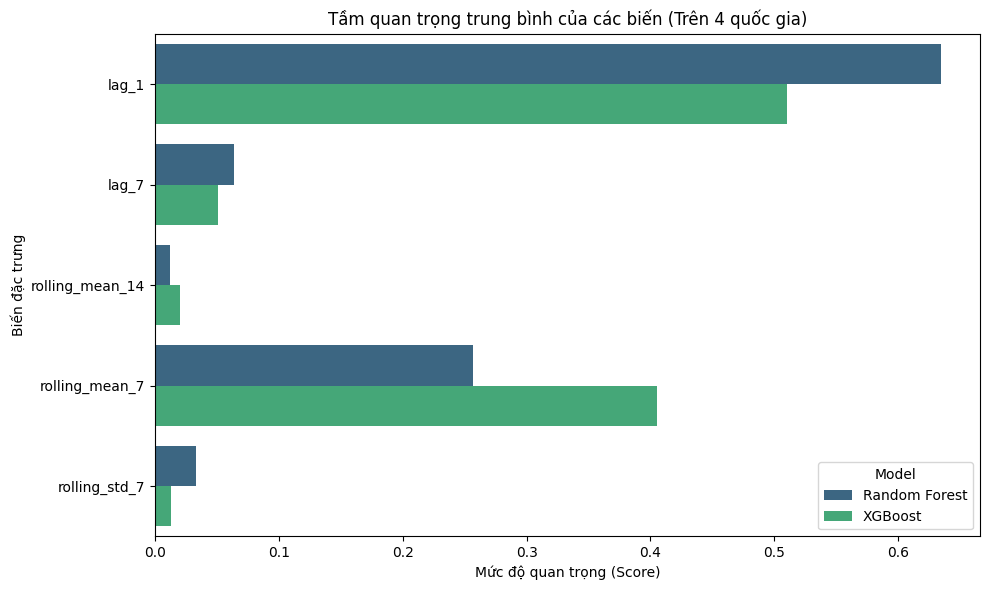

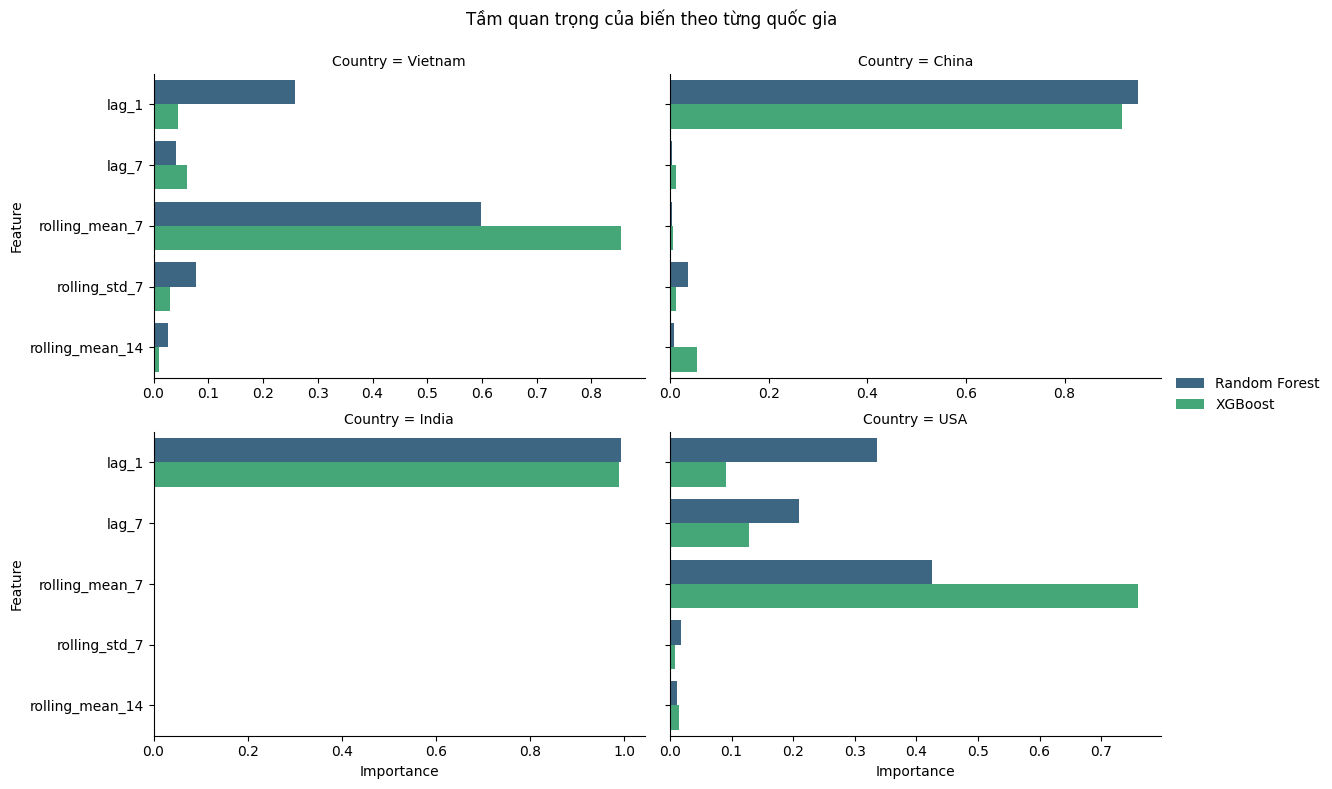

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# ==========================================
# 1. TÍNH TOÁN TẦM QUAN TRỌNG CỦA BIẾN (FEATURE IMPORTANCE)
# ==========================================
# (Đảm bảo bạn đã chạy phần tiền xử lý dữ liệu và tạo biến feature_cols ở các bước trước)

print("Đang tính toán Feature Importance...")
feature_importances = []
target_countries = {'VN': 'Vietnam', 'CN': 'China', 'IN': 'India', 'US': 'USA'}

# Vòng lặp lấy thông số quan trọng từ mô hình
for code, name in target_countries.items():
    # Lấy dữ liệu từng nước (Tương tự phần train trước đó)
    df_country = df[df['Country_code'] == code].copy()
    if df_country.empty: continue
    
    # Preprocess nhanh để lấy tập train
    df_ts = df_country.groupby('Date_reported')[target_col].sum().reset_index()
    all_dates = pd.date_range(start=df_ts['Date_reported'].min(), end=df_ts['Date_reported'].max(), freq='D')
    df_ts = df_ts.set_index('Date_reported').reindex(all_dates).fillna(0).reset_index()
    df_ts.rename(columns={'index': 'Date_reported'}, inplace=True)
    
    df_feat = create_features(df_ts) # Sử dụng hàm create_features đã định nghĩa
    X = df_feat[feature_cols]
    y = df_feat[target_col]
    
    if len(X) < 50: continue
    
    # Huấn luyện nhanh 2 mô hình Tree-based
    rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
    gb = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42).fit(X, y)
    
    # Lưu kết quả
    for i, col in enumerate(feature_cols):
        feature_importances.append({"Country": name, "Model": "Random Forest", "Feature": col, "Importance": rf.feature_importances_[i]})
        feature_importances.append({"Country": name, "Model": "XGBoost", "Feature": col, "Importance": gb.feature_importances_[i]})

# ==========================================
# 2. VẼ BIỂU ĐỒ FEATURE IMPORTANCE
# ==========================================
fi_df = pd.DataFrame(feature_importances)

# Biểu đồ 1: Trung bình tất cả các nước
plt.figure(figsize=(10, 6))
avg_fi = fi_df.groupby(['Model', 'Feature'])['Importance'].mean().reset_index()
sns.barplot(data=avg_fi, x='Importance', y='Feature', hue='Model', palette='viridis')
plt.title('Tầm quan trọng trung bình của các biến (Trên 4 quốc gia)')
plt.xlabel('Mức độ quan trọng (Score)')
plt.ylabel('Biến đặc trưng')
plt.tight_layout()
plt.show()

# Biểu đồ 2: Chi tiết từng quốc gia
g = sns.FacetGrid(fi_df, col="Country", col_wrap=2, sharex=False, height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Importance", y="Feature", hue="Model", palette="viridis")
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Tầm quan trọng của biến theo từng quốc gia')
plt.show()

Đang vẽ biểu đồ phần dư (đã chỉnh sửa và đồng nhất dữ liệu)...


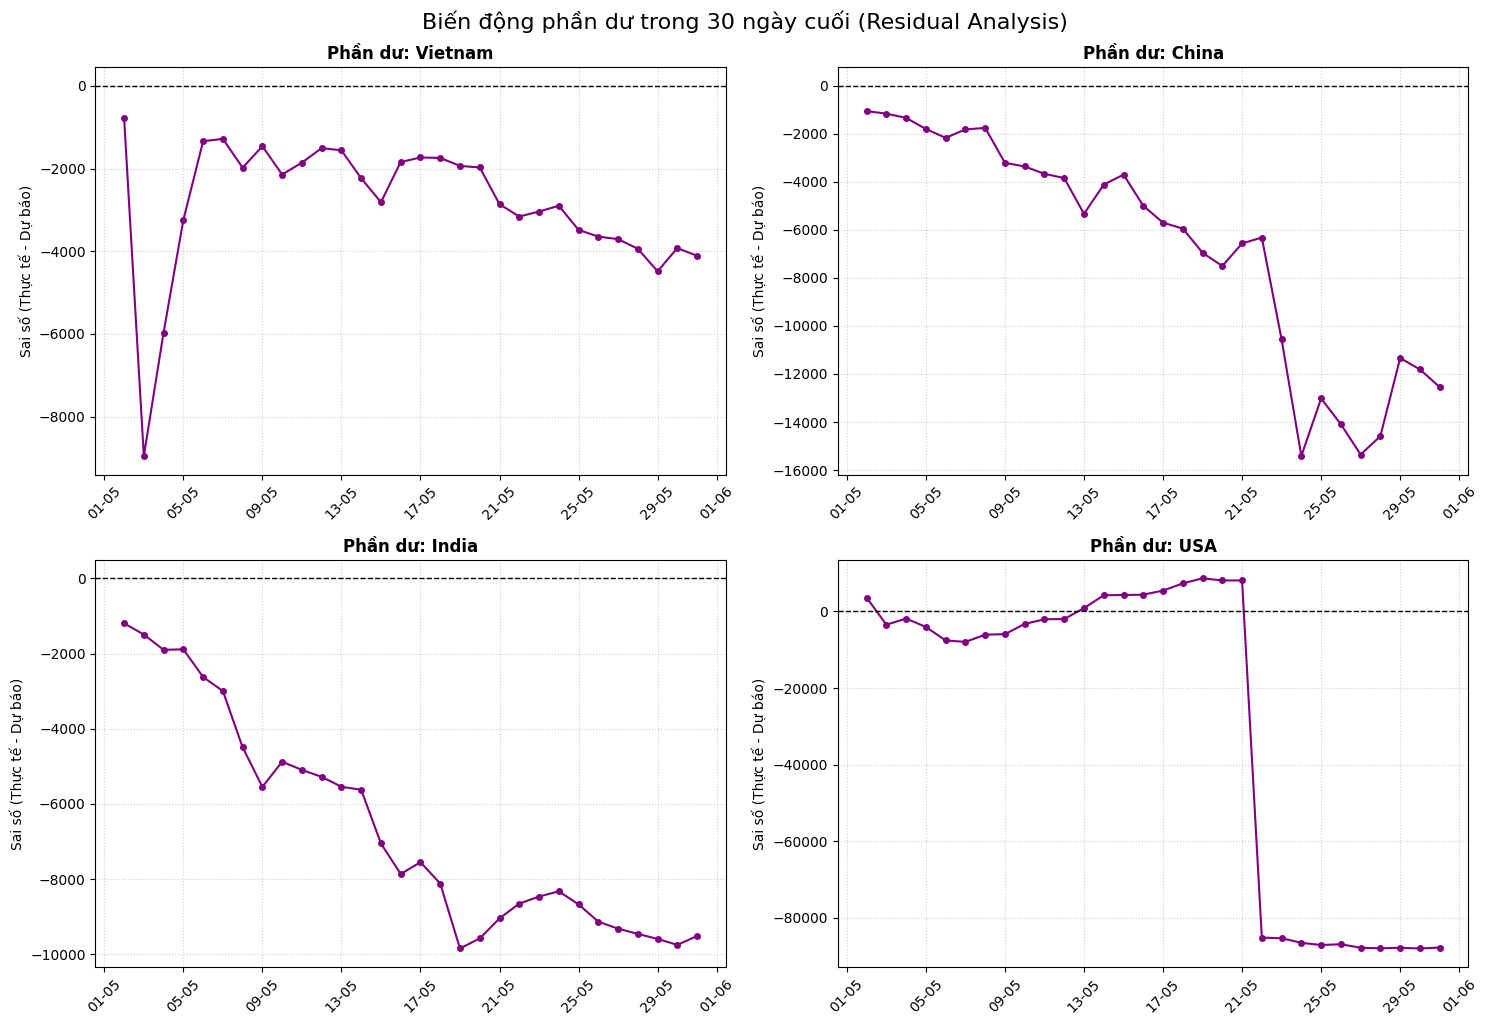

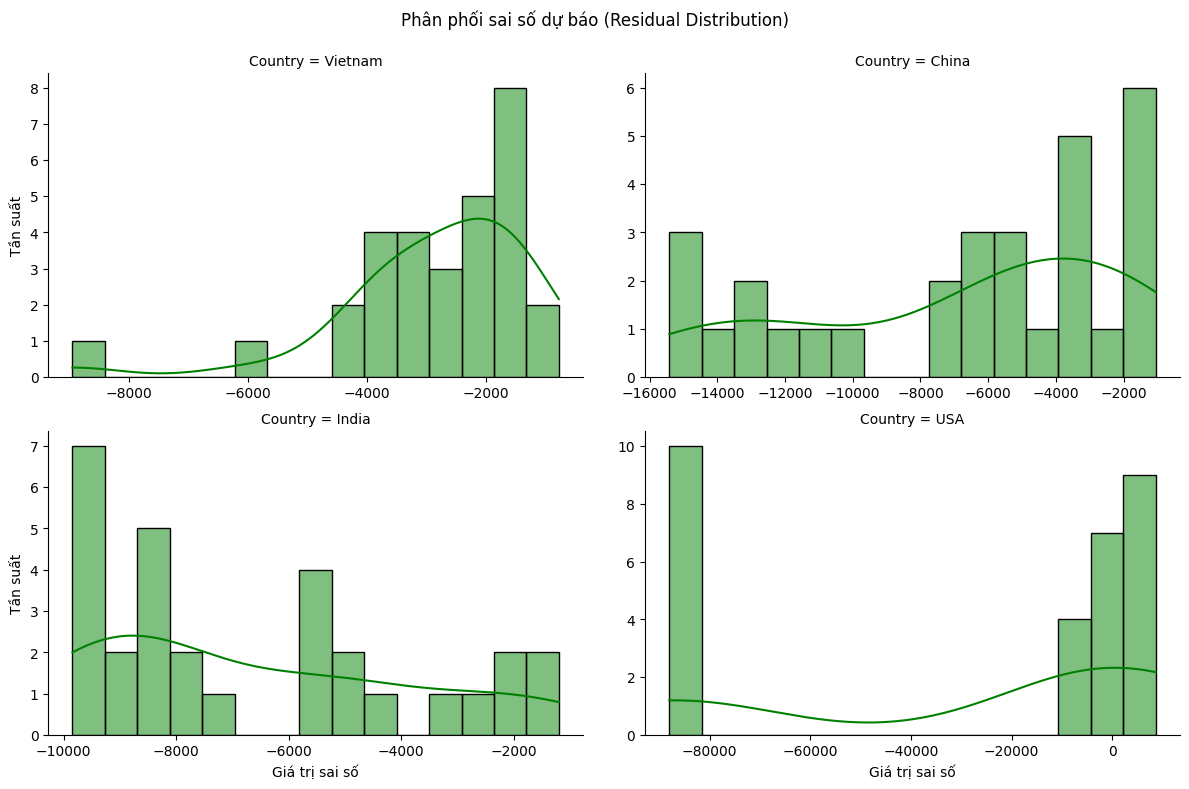

In [12]:
# ==========================================
# 4. VẼ BIỂU ĐỒ PHÂN TÍCH PHẦN DƯ 4 NƯỚC (ĐÃ KIỂM TRA TOÀN BỘ)
# ==========================================
import matplotlib.dates as mdates

print("Đang vẽ biểu đồ phần dư (đã chỉnh sửa và đồng nhất dữ liệu)...")

target_countries = {'VN': 'Vietnam', 'CN': 'China', 'IN': 'India', 'US': 'USA'}
feature_cols = ['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14']
target_col = 'New_cases'

# TẠO LIST LƯU TOÀN BỘ PHẦN DƯ CHO BIỂU ĐỒ 2
residual_list = []

# Khởi tạo subplot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (code, name) in enumerate(target_countries.items()):

    df_country = df[df['Country_code'] == code].copy()
    if df_country.empty:
        continue

    # Chuẩn hóa timeline
    df_ts = df_country.groupby('Date_reported')[target_col].sum().reset_index()
    all_dates = pd.date_range(start=df_ts['Date_reported'].min(),
                              end=df_ts['Date_reported'].max(), freq='D')

    df_ts = df_ts.set_index('Date_reported').reindex(all_dates).fillna(0).reset_index()
    df_ts.rename(columns={'index': 'Date_reported'}, inplace=True)

    # Tạo đặc trưng
    df_feat = create_features(df_ts)
    if len(df_feat) < 60:
        continue

    # Train/Test Split
    test_days = 30
    train_data = df_feat.iloc[:-test_days]
    test_data = df_feat.iloc[-test_days:]

    X_train = train_data[feature_cols]
    y_train = train_data[target_col]

    # Huấn luyện
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Dự báo theo chuỗi
    history = train_data[target_col].tolist()
    preds = []

    for _ in range(test_days):
        curr = pd.Series(history)
        feat_input = np.array([[
            curr.iloc[-1],
            curr.iloc[-7],
            curr.iloc[-7:].mean(),
            curr.iloc[-7:].std(),
            curr.iloc[-14:].mean()
        ]])

        p = max(0, model.predict(feat_input)[0])
        preds.append(p)
        history.append(p)

    # TÍNH PHẦN DƯ
    residuals = test_data[target_col].values - np.array(preds)
    dates = test_data['Date_reported']

    # LƯU VÀO DANH SÁCH CHUNG (CHO BIỂU ĐỒ 2)
    for d, r in zip(dates, residuals):
        residual_list.append([name, d, r])

    # Vẽ biểu đồ 1
    ax = axes[idx]
    ax.plot(dates, residuals, marker='o', linestyle='-', color='purple',
            markersize=4, label='Residuals')
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    ax.set_title(f'Phần dư: {name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Sai số (Thực tế - Dự báo)')
    ax.grid(True, linestyle=':', alpha=0.6)

    # Fix lỗi đè ngày
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Biến động phần dư trong 30 ngày cuối (Residual Analysis)',
             y=1.02, fontsize=16)
plt.show()


# ==========================================
# 5. BIỂU ĐỒ 2 – PHÂN PHỐI PHẦN DƯ
# ==========================================

# CHUYỂN residual_list → DataFrame
res_df = pd.DataFrame(residual_list, columns=['Country', 'Date', 'Residual'])

# Vẽ histogram
g = sns.FacetGrid(res_df, col="Country", col_wrap=2,
                  sharey=False, sharex=False, height=4, aspect=1.5)
g.map(sns.histplot, "Residual", kde=True, color="green", bins=15)

g.set_axis_labels("Giá trị sai số", "Tần suất")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Phân phối sai số dự báo (Residual Distribution)')
plt.show()


Đang vẽ biểu đồ phần dư (đã chỉnh sửa và đồng nhất dữ liệu)...


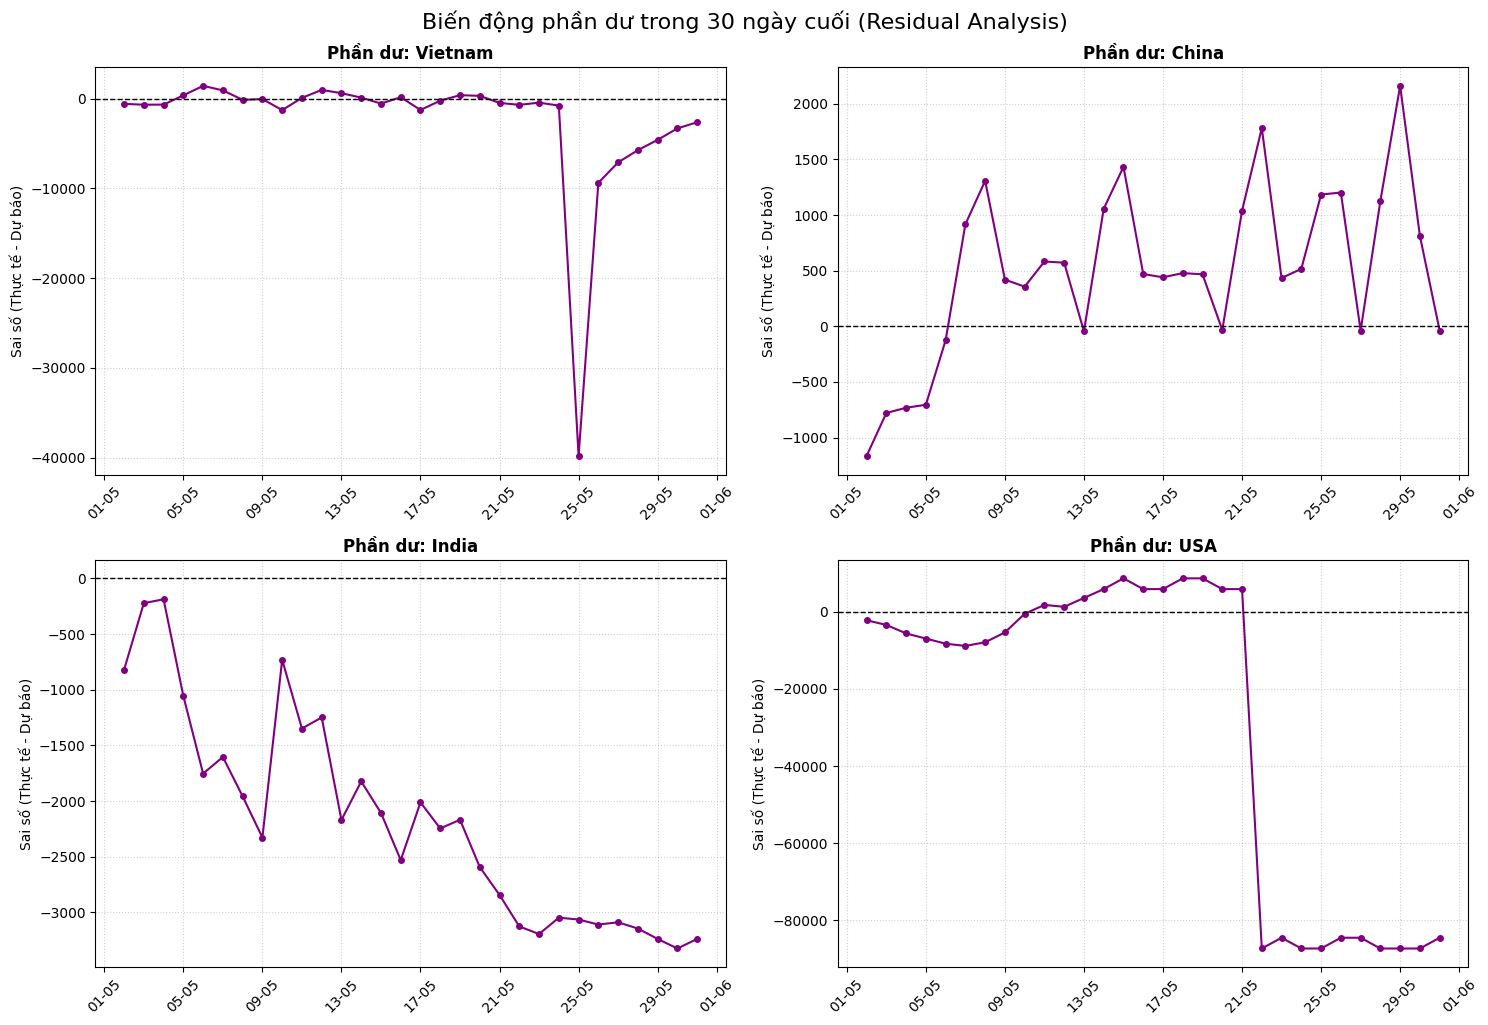

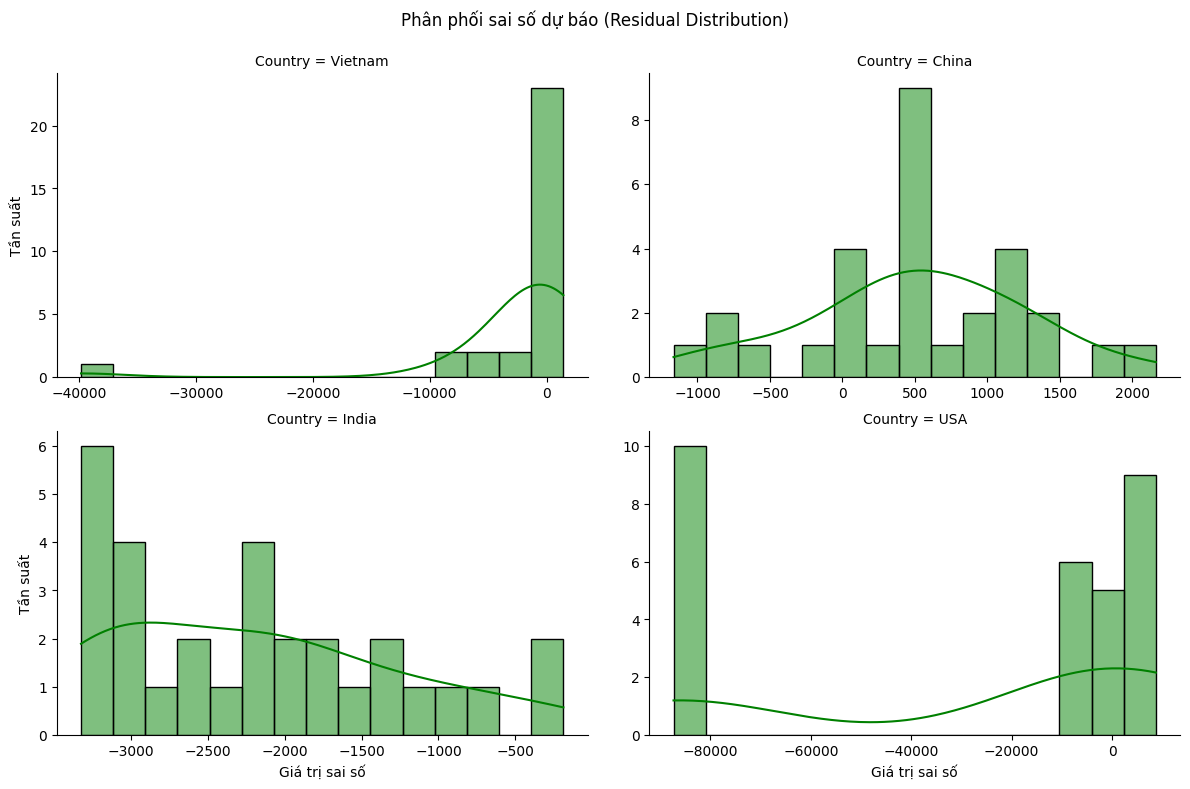

In [13]:
# ==========================================
# 4. VẼ BIỂU ĐỒ PHÂN TÍCH PHẦN DƯ 4 NƯỚC (ĐÃ KIỂM TRA TOÀN BỘ)
# ==========================================
import matplotlib.dates as mdates

print("Đang vẽ biểu đồ phần dư (đã chỉnh sửa và đồng nhất dữ liệu)...")

target_countries = {'VN': 'Vietnam', 'CN': 'China', 'IN': 'India', 'US': 'USA'}
feature_cols = ['lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14']
target_col = 'New_cases'

# TẠO LIST LƯU TOÀN BỘ PHẦN DƯ CHO BIỂU ĐỒ 2
residual_list = []

# Khởi tạo subplot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (code, name) in enumerate(target_countries.items()):

    df_country = df[df['Country_code'] == code].copy()
    if df_country.empty:
        continue

    # Chuẩn hóa timeline
    df_ts = df_country.groupby('Date_reported')[target_col].sum().reset_index()
    all_dates = pd.date_range(start=df_ts['Date_reported'].min(),
                              end=df_ts['Date_reported'].max(), freq='D')

    df_ts = df_ts.set_index('Date_reported').reindex(all_dates).fillna(0).reset_index()
    df_ts.rename(columns={'index': 'Date_reported'}, inplace=True)

    # Tạo đặc trưng
    df_feat = create_features(df_ts)
    if len(df_feat) < 60:
        continue

    # Train/Test Split
    test_days = 30
    train_data = df_feat.iloc[:-test_days]
    test_data = df_feat.iloc[-test_days:]

    X_train = train_data[feature_cols]
    y_train = train_data[target_col]

    # Huấn luyện
    model = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42).fit(X, y)
    model.fit(X_train, y_train)

    # Dự báo theo chuỗi
    history = train_data[target_col].tolist()
    preds = []

    for _ in range(test_days):
        curr = pd.Series(history)
        feat_input = np.array([[
            curr.iloc[-1],
            curr.iloc[-7],
            curr.iloc[-7:].mean(),
            curr.iloc[-7:].std(),
            curr.iloc[-14:].mean()
        ]])

        p = max(0, model.predict(feat_input)[0])
        preds.append(p)
        history.append(p)

    # TÍNH PHẦN DƯ
    residuals = test_data[target_col].values - np.array(preds)
    dates = test_data['Date_reported']

    # LƯU VÀO DANH SÁCH CHUNG (CHO BIỂU ĐỒ 2)
    for d, r in zip(dates, residuals):
        residual_list.append([name, d, r])

    # Vẽ biểu đồ 1
    ax = axes[idx]
    ax.plot(dates, residuals, marker='o', linestyle='-', color='purple',
            markersize=4, label='Residuals')
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    ax.set_title(f'Phần dư: {name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Sai số (Thực tế - Dự báo)')
    ax.grid(True, linestyle=':', alpha=0.6)

    # Fix lỗi đè ngày
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Biến động phần dư trong 30 ngày cuối (Residual Analysis)',
             y=1.02, fontsize=16)
plt.show()


# ==========================================
# 5. BIỂU ĐỒ 2 – PHÂN PHỐI PHẦN DƯ
# ==========================================

# CHUYỂN residual_list → DataFrame
res_df = pd.DataFrame(residual_list, columns=['Country', 'Date', 'Residual'])

# Vẽ histogram
g = sns.FacetGrid(res_df, col="Country", col_wrap=2,
                  sharey=False, sharex=False, height=4, aspect=1.5)
g.map(sns.histplot, "Residual", kde=True, color="green", bins=15)

g.set_axis_labels("Giá trị sai số", "Tần suất")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Phân phối sai số dự báo (Residual Distribution)')
plt.show()
